In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gridworld size
grid_size = 5

# Discount factor
gamma = 0.95

# Special states, rewards and next states
special_states = {
    (0, 1): {"reward": 5, "next_state": (3, 2)},
    (0, 4): {"reward": 2.5, "next_state_prob": [(4, 4), (3, 2)], "prob": [0.5, 0.5]},
}

# Initialize rewards
rewards = np.zeros((grid_size, grid_size))
for states in special_states:
    rewards[states]=special_states[states]["reward"]

# Initialize transitions
transitions = {}
for i in range(grid_size):
    for j in range(grid_size):
        state = (i, j)
        transitions[state] = {
            "up": (max(i - 1, 0), j),
            "down": (min(i + 1, grid_size - 1), j),
            "left": (i, max(j - 1, 0)),
            "right": (i, min(j + 1, grid_size - 1)),
        }

# policy: moves to one of the four directions with equal probability of 0.25
policy = {
    (i, j): {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
    for i in range(grid_size)
    for j in range(grid_size)
}


In [2]:
# Function to plot the gridworld
def plot_gridworld(policy,Title):
    grid_size = 5
    fig, ax = plt.subplots(figsize=(8, 8))

    rect1 = plt.Rectangle((0.5,-0.5), 1, 1, facecolor='blue', edgecolor='black')
    ax.add_patch(rect1)
    rect2 = plt.Rectangle((3.5,-0.5), 1, 1, facecolor='green', edgecolor='black')
    ax.add_patch(rect2)
    rect3 = plt.Rectangle((1.5,2.5), 1, 1, facecolor='red', edgecolor='black')
    ax.add_patch(rect3)
    rect4 = plt.Rectangle((3.5,3.5), 1, 1, facecolor='yellow', edgecolor='black')
    ax.add_patch(rect4)

    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, round(policy[i,j],2), ha='center', va='center', fontsize=8) # rounded value
            # ax.text(j, i, policy[i,j], ha='center', va='center', fontsize=8) # absolute value

    
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')
    ax.set_xticks(np.arange(-0.5, grid_size, 1), minor=False)
    ax.set_yticks(np.arange(-0.5, grid_size, 1), minor=False)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    plt.title(Title)
    plt.gca().invert_yaxis()
    plt.show()

In [3]:
# Function to calculate transition probabilities, rewards, total value and individual values
def get_transition_rewards(state, policy, V):
    i, j = state
    transition_probs = np.zeros((grid_size, grid_size))
    reward = 0
    rewardss=[]
    r = 0
    value = 0
    values = []

    if state in special_states:
        if (i, j) == (0, 4):
            for next_state, prob in zip(special_states[state]["next_state_prob"], special_states[state]["prob"]):
                transition_probs[next_state] += prob
                reward += rewards[i, j]*prob
                value += prob * (rewards[i, j] + gamma * V[next_state])
            values.append(value)
        else:
            transition_probs[special_states[state]["next_state"]] = 1
            next_state = special_states[state]["next_state"]
            reward = rewards[i, j]
            value = rewards[i, j] + gamma * V[next_state]
            values.append(value)
    else:
        for action, prob in policy[state].items():
            next_state = transitions[state][action]
            r = -0.5 if next_state == state else 0
            rewardss.append( r * prob)
            reward=max(rewardss)
            value += prob * (r + gamma * V[next_state])    
            transition_probs[next_state] += prob
            # values.append(prob*(r + gamma * V[next_state]))
            values.append(r + gamma * V[next_state])

    return transition_probs, reward, value, values

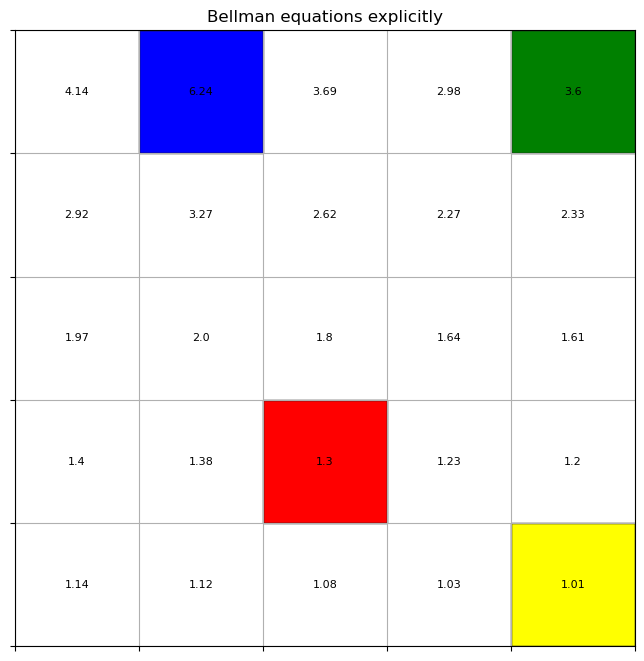

In [4]:
# Bellman equations explicitly
from scipy.linalg import solve

# Construct the linear system of equations
A = np.zeros((grid_size**2, grid_size**2))
b = np.zeros(grid_size**2)

V = np.zeros((grid_size, grid_size))

# Calculate transition probability and expected reward matrices
for i in range(grid_size):
    for j in range(grid_size):
        state_index = i * grid_size + j
        transition_probs, reward, value, values2 = get_transition_rewards((i, j), policy, V)
        A[state_index, :] = -gamma * transition_probs.flatten() # gamma*P
        A[state_index, state_index] += 1                        # (I-gamma*P)
        b[state_index] = reward                                 # Reward

# Solve the linear system
values = np.linalg.inv(A).dot(b)
values = values.reshape((grid_size, grid_size))
# print(values)
plot_gridworld(values,"Bellman equations explicitly")

# One step look ahead to find optimal policy


In [5]:

# Gridworld dimensions
grid_size = 5

# Discount factor
gamma = 0.95

# Initialize the value function
V = np.zeros((grid_size, grid_size))

# Define the actions
actions = ['up', 'down', 'left', 'right']
action_probs = [0.25, 0.25, 0.25, 0.25]

# Define the special states and their effects
special_states = {
    (0, 1): (3, 2, 5),
    (0, 4): [(4, 4, 2.5, 0.5), (3, 2, 2.5, 0.5)]
}

# Returen next S' and R(t+1) once St and At is given
def get_next_state_and_reward(state, action):
    if state in special_states:
        if state == (0, 4):
            next_state = special_states[state][np.random.choice([0, 1], p=[0.5, 0.5])]
            return (next_state[0], next_state[1]), next_state[2]
        return special_states[state][:2], special_states[state][2]

    x, y = state
    if action == 'up':
        x = max(x - 1, 0)
    elif action == 'down':
        x = min(x + 1, grid_size - 1)
    elif action == 'left':
        y = max(y - 1, 0)
    elif action == 'right':
        y = min(y + 1, grid_size - 1)

    # reward is 0 for normal states, -0.5 for attempts to step off the grid
    reward = 0
    if (x, y) == state:  # Attempt to step off the grid
        reward = -0.5

    return (x, y), reward


# Initialize the policy
policy = {}
for i in range(grid_size):
    for j in range(grid_size):
        policy[(i, j)] = np.random.choice(actions, p=action_probs)
        

In [6]:
# Function to plot the gridworld
def plot_gridworld(policy,Title):
    grid_size = 5
    fig, ax = plt.subplots(figsize=(8, 8))

    rect1 = plt.Rectangle((0.5,-0.5), 1, 1, facecolor='blue', edgecolor='black')
    ax.add_patch(rect1)
    rect2 = plt.Rectangle((3.5,-0.5), 1, 1, facecolor='green', edgecolor='black')
    ax.add_patch(rect2)
    rect3 = plt.Rectangle((1.5,2.5), 1, 1, facecolor='red', edgecolor='black')
    ax.add_patch(rect3)
    rect4 = plt.Rectangle((3.5,3.5), 1, 1, facecolor='yellow', edgecolor='black')
    ax.add_patch(rect4)

    for i in range(grid_size):
        for j in range(grid_size):
            # ax.text(j, i, round(policy[i,j],2), ha='center', va='center', fontsize=8)
            ax.text(j, i, policy[i,j], ha='center', va='center', fontsize=8)

    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')
    ax.set_xticks(np.arange(-0.5, grid_size, 1), minor=False)
    ax.set_yticks(np.arange(-0.5, grid_size, 1), minor=False)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    plt.title(Title)
    plt.gca().invert_yaxis()
    plt.show()

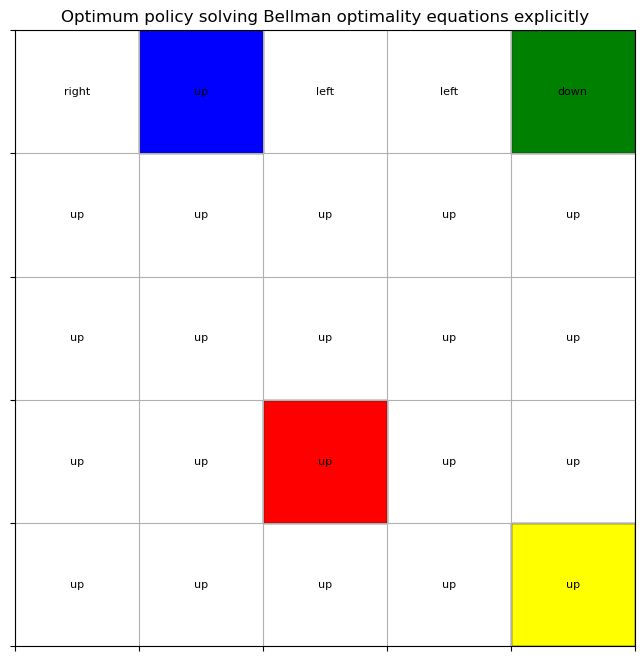

In [7]:
# One step look ahead to find optimal policy
for x in range(grid_size):
    for y in range(grid_size):
        action_values = []
        for action in actions:
            (new_x, new_y), reward = get_next_state_and_reward((x, y), action)
            action_values.append(reward + gamma * values[new_x, new_y])
        best_action = actions[np.argmax(action_values)]
        # best_action=action_search(np.ceil(action_values * 100) / 100)
        policy[(x, y)] = best_action

OA=np.full((grid_size, grid_size), "", dtype=object)
for x in range(grid_size):
    for y in range(grid_size):
        OA[x, y] = policy[x, y]
plot_gridworld(OA,"Optimum policy solving Bellman optimality equations explicitly")